# PyPath Input Module Analysis Report

This notebook analyzes the categorization results from all 10 groups of PyPath input modules to provide comprehensive insights into the maintenance status, technical characteristics, and biological coverage of the codebase.

In [13]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import numpy as np
from pathlib import Path

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Preprocessing

In [14]:
# Load all result files
all_modules = []
group_counts = {}

for i in range(1, 11):
    try:
        with open(f'result-{i}.yaml', 'r') as f:
            data = yaml.safe_load(f)
            if 'modules' in data:
                modules = data['modules']
                print(f"Group {i}: {len(modules)} modules loaded")
                group_counts[i] = len(modules)
                
                # Add group number to each module
                for module in modules:
                    module['group'] = i
                    all_modules.extend([module])
            else:
                print(f"Group {i}: No 'modules' key found in file")
    except FileNotFoundError:
        print(f"Group {i}: File result-{i}.yaml not found")
    except Exception as e:
        print(f"Group {i}: Error loading file - {e}")

print(f"\nTotal modules loaded: {len(all_modules)}")
print(f"Group distribution: {group_counts}")

Group 1: 20 modules loaded
Group 2: 19 modules loaded
Group 3: 20 modules loaded
Group 4: 20 modules loaded
Group 5: 20 modules loaded
Group 6: 20 modules loaded
Group 7: 20 modules loaded
Group 8: 20 modules loaded
Group 9: 19 modules loaded
Group 10: 4 modules loaded

Total modules loaded: 182
Group distribution: {1: 20, 2: 19, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 19, 10: 4}


## 2. Basic Statistics

In [15]:
# Extract basic statistics
def extract_field(modules, field_path):
    """Extract nested field values from modules"""
    values = []
    for module in modules:
        try:
            current = module
            for key in field_path.split('.'):
                current = current[key]
            values.append(current)
        except (KeyError, TypeError):
            values.append(None)
    return values

# Create a summary DataFrame
summary_data = {
    'module_name': [m['module_name'] for m in all_modules],
    'group': [m['group'] for m in all_modules],
    'maintenance_category': extract_field(all_modules, 'maintenance_status.category'),
    'module_type': extract_field(all_modules, 'module_type'),
    'status': extract_field(all_modules, 'status'),
    'species_coverage': extract_field(all_modules, 'species_coverage'),
    'functions_count': [len(m.get('functions', [])) for m in all_modules]
}

df = pd.DataFrame(summary_data)
print(f"DataFrame shape: {df.shape}")
print(f"\nFirst 5 rows:")
df.head()

DataFrame shape: (182, 7)

First 5 rows:


,module_name,group,maintenance_category,module_type,status,species_coverage,functions_count
0,transmir,1,infrequent,[primary_data],success,human_only,1
1,lncdisease,1,discontinued,[primary_data],success,multi_species,1
2,icellnet,1,frequent,[primary_data],success,human_only,3
3,ipi,1,discontinued,[id_mapping],success,multi_species,1
4,ca1,1,one_time_paper,[primary_data],success,human_only,1


## 3. Maintenance Status Analysis

Maintenance Status Distribution:
  frequent: 61 modules (33.5%)
  discontinued: 45 modules (24.7%)
  infrequent: 38 modules (20.9%)
  one_time_paper: 27 modules (14.8%)


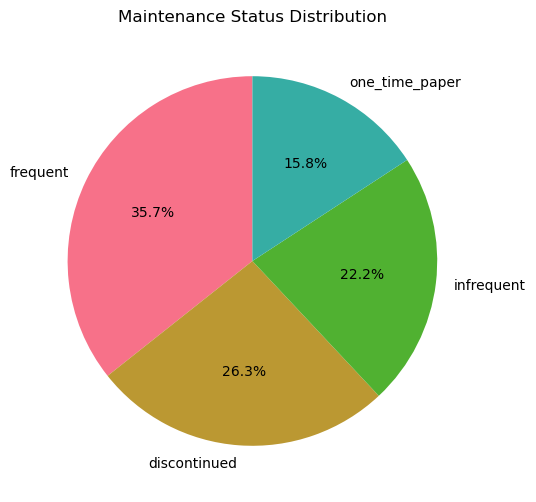

In [16]:
# Maintenance status distribution
maintenance_counts = df['maintenance_category'].value_counts()
print("Maintenance Status Distribution:")
for status, count in maintenance_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {status}: {count} modules ({percentage:.1f}%)")

# Create visualization
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 6))

# Pie chart
maintenance_counts.plot(kind='pie', ax=ax1, autopct='%1.1f%%', startangle=90)
ax1.set_title('Maintenance Status Distribution')
ax1.set_ylabel('')

plt.show()

## 4. Module Type and Status Analysis

Module Type Distribution:
  primary_data: 159 modules
  utility: 16 modules
  id_mapping: 15 modules

Status Distribution:
  success: 149 modules (81.9%)
  error: 18 modules (9.9%)
  timeout: 14 modules (7.7%)


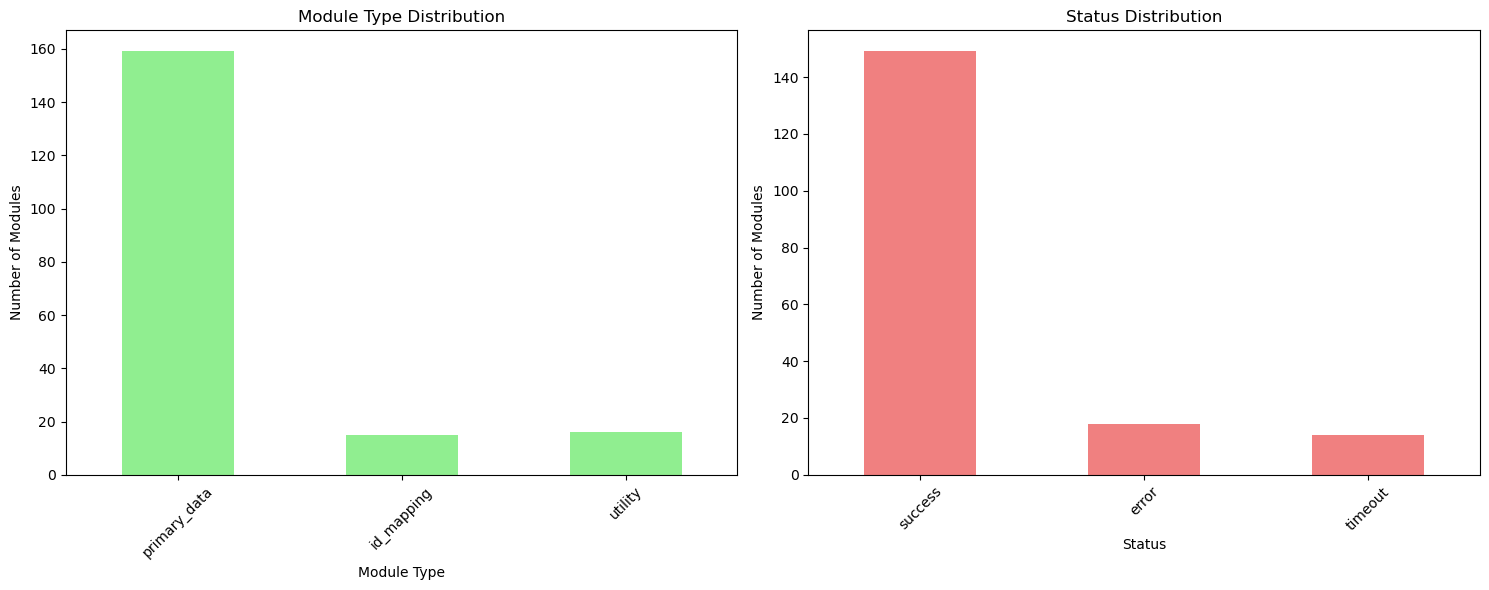

In [17]:
# Module type distribution
module_types = []
for module in all_modules:
    types = module.get('module_type', [])
    if isinstance(types, list):
        module_types.extend(types)
    else:
        module_types.append(types)

module_type_counts = Counter(module_types)
print("Module Type Distribution:")
for mtype, count in module_type_counts.most_common():
    print(f"  {mtype}: {count} modules")

# Status distribution
status_counts = df['status'].value_counts()
print("\nStatus Distribution:")
for status, count in status_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {status}: {count} modules ({percentage:.1f}%)")

# Visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Module types
pd.Series(module_type_counts).plot(kind='bar', ax=ax1, color='lightgreen')
ax1.set_title('Module Type Distribution')
ax1.set_xlabel('Module Type')
ax1.set_ylabel('Number of Modules')
ax1.tick_params(axis='x', rotation=45)

# Status distribution
status_counts.plot(kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Status Distribution')
ax2.set_xlabel('Status')
ax2.set_ylabel('Number of Modules')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Cross-tabulation of Maintenance Category vs Status:
status                error  success  timeout  All
maintenance_category                              
discontinued              3       40        2   45
frequent                  7       44       10   61
infrequent                5       31        2   38
one_time_paper            0       27        0   27
All                      15      142       14  171


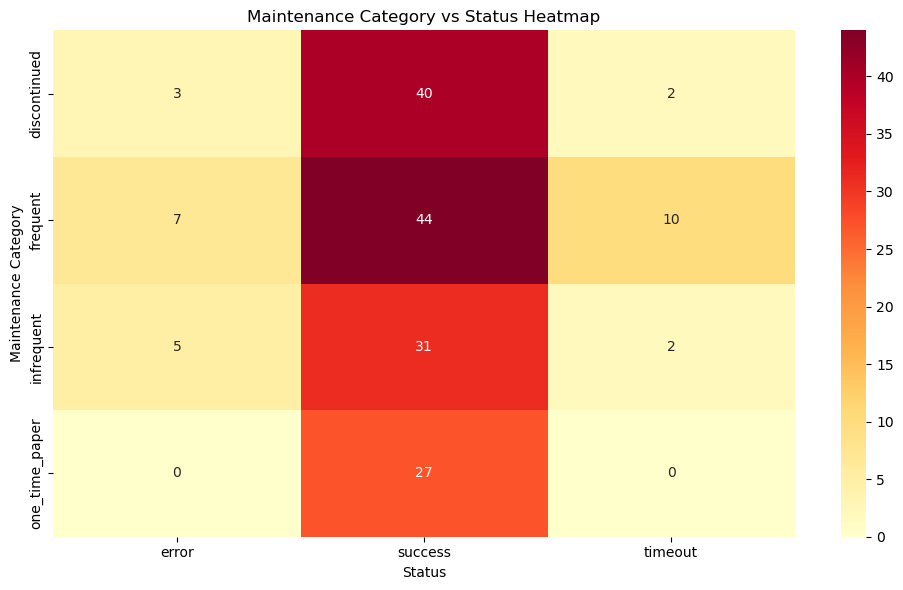

In [18]:
# Cross-tabulation of maintenance status and module status
cross_tab = pd.crosstab(df['maintenance_category'], df['status'], margins=True)
print("\nCross-tabulation of Maintenance Category vs Status:")
print(cross_tab)

# Create a heatmap for the cross-tabulation
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cross_tab.iloc[:-1, :-1], annot=True, fmt='d', cmap='YlOrRd', ax=ax)
ax.set_title('Maintenance Category vs Status Heatmap')
ax.set_xlabel('Status')
ax.set_ylabel('Maintenance Category')
plt.tight_layout()
plt.show()

## 5. Technical Aspects Analysis

Access Method Distribution:
  file_download: 149 modules
  api: 24 modules
  web_scraping: 20 modules

Top 10 Data Formats:
  tsv: 75 modules
  csv: 28 modules
  json: 19 modules
  html: 17 modules
  zip: 16 modules
  txt: 15 modules
  xml: 14 modules
  xlsx: 13 modules
  xls: 11 modules
  rda: 5 modules


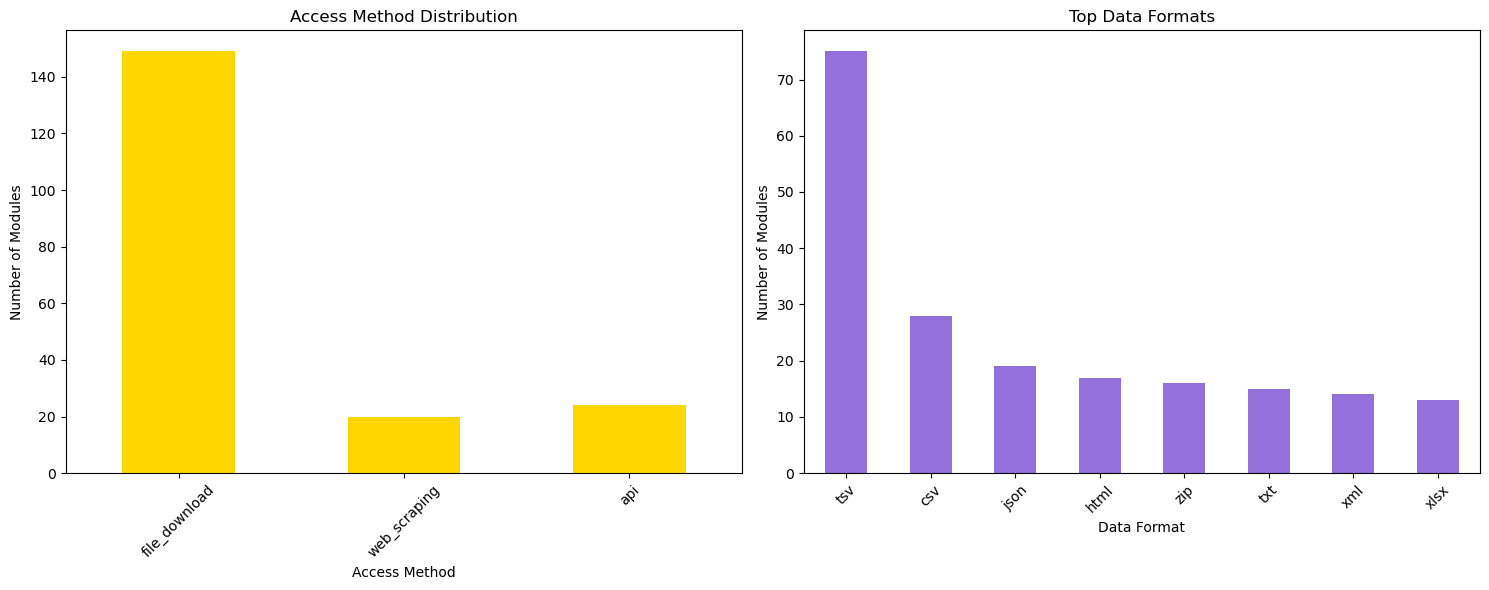

In [19]:
# Access methods
access_methods = []
data_formats = []

for module in all_modules:
    tech_aspects = module.get('technical_aspects', {})
    
    # Access methods
    methods = tech_aspects.get('access_method', [])
    if isinstance(methods, list):
        access_methods.extend(methods)
    else:
        access_methods.append(methods)
    
    # Data formats
    formats = tech_aspects.get('data_format', [])
    if isinstance(formats, list):
        data_formats.extend(formats)
    else:
        data_formats.append(formats)

access_method_counts = Counter([m for m in access_methods if m])
data_format_counts = Counter([f for f in data_formats if f])

print("Access Method Distribution:")
for method, count in access_method_counts.most_common():
    print(f"  {method}: {count} modules")

print("\nTop 10 Data Formats:")
for format_type, count in data_format_counts.most_common(10):
    print(f"  {format_type}: {count} modules")

# Visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Access methods
pd.Series(access_method_counts).plot(kind='bar', ax=ax1, color='gold')
ax1.set_title('Access Method Distribution')
ax1.set_xlabel('Access Method')
ax1.set_ylabel('Number of Modules')
ax1.tick_params(axis='x', rotation=45)

# Top data formats
top_formats = dict(data_format_counts.most_common(8))
pd.Series(top_formats).plot(kind='bar', ax=ax2, color='mediumpurple')
ax2.set_title('Top Data Formats')
ax2.set_xlabel('Data Format')
ax2.set_ylabel('Number of Modules')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Biological Entity and Annotation Analysis

In [20]:
# Extract biological tags with module names
from collections import defaultdict

entity_modules = defaultdict(list)
annotation_modules = defaultdict(list)
interaction_modules = defaultdict(list)

for module in all_modules:
    module_name = module.get('module_name', 'unknown')
    tags = module.get('tags', {})
    
    # Entities
    entity_tags = tags.get('entity', [])
    if isinstance(entity_tags, list):
        for entity in entity_tags:
            if entity:
                entity_modules[entity].append(module_name)
    elif entity_tags:
        entity_modules[entity_tags].append(module_name)
    
    # Annotations
    annotation_tags = tags.get('annotation', [])
    if isinstance(annotation_tags, list):
        for annotation in annotation_tags:
            if annotation:
                annotation_modules[annotation].append(module_name)
    elif annotation_tags:
        annotation_modules[annotation_tags].append(module_name)
    
    # Interactions
    interaction_tags = tags.get('interaction', [])
    if isinstance(interaction_tags, list):
        for interaction in interaction_tags:
            if interaction:
                interaction_modules[interaction].append(module_name)
    elif interaction_tags:
        interaction_modules[interaction_tags].append(module_name)

# Count occurrences for sorting
entity_counts = {k: len(v) for k, v in entity_modules.items()}
annotation_counts = {k: len(v) for k, v in annotation_modules.items()}
interaction_counts = {k: len(v) for k, v in interaction_modules.items()}

# Print results
print("Entity Type Distribution:")
for entity, count in sorted(entity_counts.items(), key=lambda x: x[1], reverse=True):
    modules = ', '.join(sorted(entity_modules[entity]))
    print(f"  {entity}: {count} modules ({modules})")

print("\nAnnotation Type Distribution:")
for annotation, count in sorted(annotation_counts.items(), key=lambda x: x[1], reverse=True):
    modules = ', '.join(sorted(annotation_modules[annotation]))
    print(f"  {annotation}: {count} modules ({modules})")

print("\nInteraction Type Distribution:")
for interaction, count in sorted(interaction_counts.items(), key=lambda x: x[1], reverse=True):
    modules = ', '.join(sorted(interaction_modules[interaction]))
    print(f"  {interaction}: {count} modules ({modules})")

# Write results to file
with open('biological_tags_analysis.txt', 'w') as f:
    f.write("PyPath Module Biological Tags Analysis\n")
    f.write("=" * 50 + "\n\n")
    
    f.write("ENTITY TYPE DISTRIBUTION:\n")
    f.write("-" * 30 + "\n")
    for entity, count in sorted(entity_counts.items(), key=lambda x: x[1], reverse=True):
        modules = ', '.join(sorted(entity_modules[entity]))
        f.write(f"{entity}: {count} modules\n")
        f.write(f"  Modules: {modules}\n\n")
    
    f.write("\nANNOTATION TYPE DISTRIBUTION:\n")
    f.write("-" * 30 + "\n")
    for annotation, count in sorted(annotation_counts.items(), key=lambda x: x[1], reverse=True):
        modules = ', '.join(sorted(annotation_modules[annotation]))
        f.write(f"{annotation}: {count} modules\n")
        f.write(f"  Modules: {modules}\n\n")
    
    f.write("\nINTERACTION TYPE DISTRIBUTION:\n")
    f.write("-" * 30 + "\n")
    for interaction, count in sorted(interaction_counts.items(), key=lambda x: x[1], reverse=True):
        modules = ', '.join(sorted(interaction_modules[interaction]))
        f.write(f"{interaction}: {count} modules\n")
        f.write(f"  Modules: {modules}\n\n")

print(f"\nDetailed results written to 'biological_tags_analysis.txt'")

Entity Type Distribution:
  protein: 150 modules (abs, acsn, adhesome, almen2009, baccin2019, biogps, biogrid, ca1, cancercellmap, cancerdrugsdb, cancersea, cellcall, cellcellinteractions, cellchatdb, cellinker, cellphonedb, celltalkdb, celltypist, clinvar, collectri, compath, comppi, connectomedb, cosmic, cpad, cpdb, csa, cspa, ctdbase, cytosig, dbptm, deathdomain, depod, dgidb, dip, diseases, disgenet/_api/simple, domino, dorothea, drugbank, drugcentral, ebi, elm, embrace, encode, exocarta, expasy, genecards, gpcrdb, guide2pharma, gutmgene, hgnc, hippie, homologene, hpmr, hpo, hprd, htri, humancellmap, humsavar, huri, i3d, icellnet, innatedb, instruct, intact, integrins, interpro, intogen, ipi, iptmnet, italk, kea, kegg, kegg_api, kinasedotcom, kirouac2010, lambert2018, laudanna, li2012, lmpid, lncrnadb, locate, lrdb, macrophage, matrisome, matrixdb, mcam, membranome, mimp, mir2disease, mirdeathdb, mirecords, mirtarbase, mppi, msigdb, ncrdeathdb, negatome, netbiol, netpath, new_stitc

In [21]:
# Status analysis by maintenance category
print("Status Distribution by Maintenance Category:")
print("=" * 50)

for category in df['maintenance_category'].unique():
    if pd.notna(category):
        category_data = df[df['maintenance_category'] == category]
        status_dist = category_data['status'].value_counts()
        
        print(f"\n{category.upper()} ({len(category_data)} modules):")
        for status, count in status_dist.items():
            percentage = (count / len(category_data)) * 100
            print(f"  {status}: {count} modules ({percentage:.1f}%)")

# Identify modules that need attention (error or timeout status)
problematic_modules = df[df['status'].isin(['error', 'timeout'])]
print(f"\n\nModules Needing Attention ({len(problematic_modules)} modules):")
print("=" * 50)

for _, module in problematic_modules.iterrows():
    print(f"  {module['module_name']} (Group {module['group']}): {module['status']} - {module['maintenance_category']}")

# Generate summary statistics
total_modules = len(df)
success_count = len(df[df['status'] == 'success'])
timeout_count = len(df[df['status'] == 'timeout'])
error_count = len(df[df['status'] == 'error'])

print(f"\n\nOVERALL SUMMARY:")
print("=" * 50)
print(f"Total modules analyzed: {total_modules}")
print(f"Successfully working: {success_count} ({success_count/total_modules*100:.1f}%)")
print(f"Timing out: {timeout_count} ({timeout_count/total_modules*100:.1f}%)")
print(f"Failing with errors: {error_count} ({error_count/total_modules*100:.1f}%)")

# Success rate by maintenance category
print(f"\nSuccess Rate by Maintenance Category:")
print("-" * 40)
for category in df['maintenance_category'].unique():
    if pd.notna(category):
        category_data = df[df['maintenance_category'] == category]
        success_rate = len(category_data[category_data['status'] == 'success']) / len(category_data) * 100
        print(f"  {category}: {success_rate:.1f}% ({len(category_data[category_data['status'] == 'success'])}/{len(category_data)} modules)")

Status Distribution by Maintenance Category:

INFREQUENT (38 modules):
  success: 31 modules (81.6%)
  error: 5 modules (13.2%)
  timeout: 2 modules (5.3%)

DISCONTINUED (45 modules):
  success: 40 modules (88.9%)
  error: 3 modules (6.7%)
  timeout: 2 modules (4.4%)

FREQUENT (61 modules):
  success: 44 modules (72.1%)
  timeout: 10 modules (16.4%)
  error: 7 modules (11.5%)

ONE_TIME_PAPER (27 modules):
  success: 27 modules (100.0%)


Modules Needing Attention (32 modules):
  oma (Group 1): timeout - infrequent
  clinvar (Group 2): timeout - frequent
  proteins (Group 3): timeout - frequent
  intogen (Group 3): timeout - frequent
  pubchem (Group 4): timeout - frequent
  deathdomain (Group 4): error - frequent
  adrecs (Group 4): error - infrequent
  msigdb (Group 4): timeout - frequent
  opentargets (Group 4): timeout - frequent
  cytosig (Group 4): error - infrequent
  mitab (Group 5): error - None
  cancercellmap (Group 5): error - discontinued
  cancerdrugsdb (Group 5): error - 

## 7. Status Analysis Summary

The status field indicates the current operational state of each module based on test results:

- **Success**: Module functions work correctly and return expected data
- **Timeout**: Module functions timeout during execution, often due to large datasets or slow responses
- **Error**: Module functions fail due to various issues (API changes, data format changes, broken URLs, etc.)


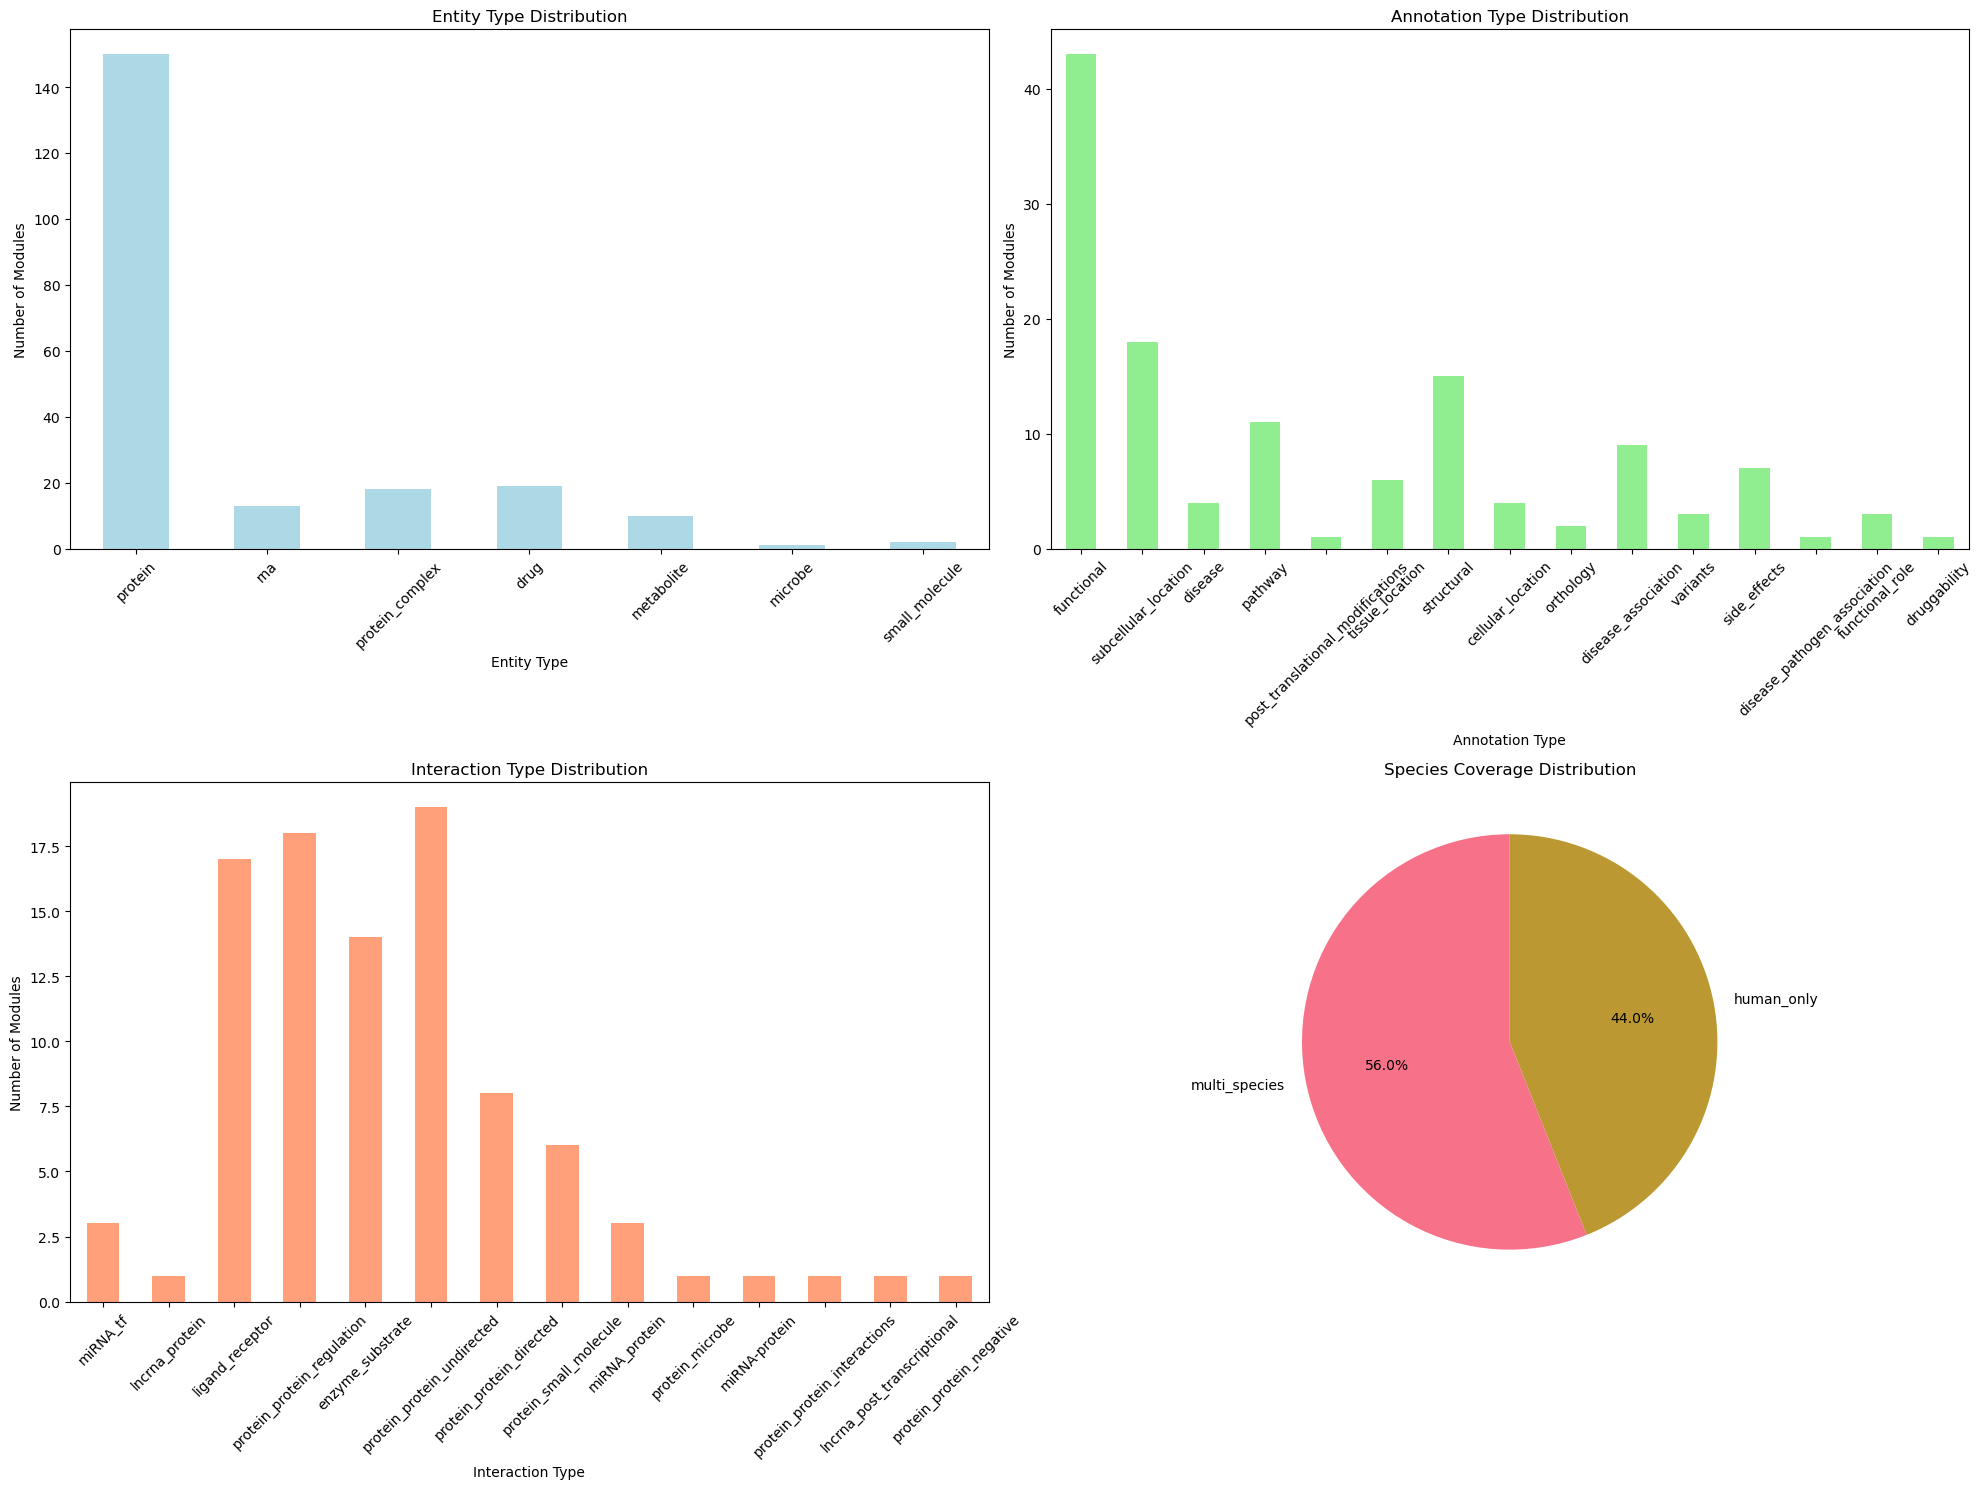

In [23]:
# Visualize biological tags
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Entity types
pd.Series(entity_counts).plot(kind='bar', ax=axes[0,0], color='lightblue')
axes[0,0].set_title('Entity Type Distribution')
axes[0,0].set_xlabel('Entity Type')
axes[0,0].set_ylabel('Number of Modules')
axes[0,0].tick_params(axis='x', rotation=45)

# Annotation types
pd.Series(annotation_counts).plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Annotation Type Distribution')
axes[0,1].set_xlabel('Annotation Type')
axes[0,1].set_ylabel('Number of Modules')
axes[0,1].tick_params(axis='x', rotation=45)

# Interaction types
pd.Series(interaction_counts).plot(kind='bar', ax=axes[1,0], color='lightsalmon')
axes[1,0].set_title('Interaction Type Distribution')
axes[1,0].set_xlabel('Interaction Type')
axes[1,0].set_ylabel('Number of Modules')
axes[1,0].tick_params(axis='x', rotation=45)

# Species coverage
species_counts = df['species_coverage'].value_counts()
species_counts.plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Species Coverage Distribution')
axes[1,1].set_ylabel('')

plt.tight_layout()
plt.show()